In [1]:
from glob import glob
import re

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gtes = sorted(glob('../data/OTB100GT/*'))
files = sorted(glob('../data/OTB100/*'))

In [3]:
assert len(gtes) == len(files)

In [4]:
def loadgt(file):
    with open(file) as f:
        return np.asarray([list(map(int, re.findall(r'[\w]+', line.strip()))) for line in f.readlines()])

In [5]:
gtboxes = [loadgt(file + '/groundtruth_rect.txt') for file in gtes]

In [6]:
results = [loadmat(file)['results'][0][0][0][0][0] for file in files]

In [7]:
def location(rect1, rect2):
    cx1, cy1 = rect1[0] + rect1[2]/2, rect1[1] + rect1[3]/2
    cx2, cy2 = rect2[0] + rect2[2]/2, rect2[1] + rect2[3]/2
    return ((cy2-cy1)**2 + (cx2-cx1)**2)**.5

In [8]:
def overlap(rect1, rect2):
    left = np.maximum(rect1[0], rect2[0])
    right = np.minimum(rect1[0] + rect1[2], rect2[0] + rect2[2])
    top = np.maximum(rect1[1], rect2[1])
    bottom = np.minimum(rect1[1] + rect1[3], rect2[1] + rect2[3])

    intersect = np.maximum(0, right - left) * np.maximum(0, bottom - top)
    union = rect1[2] * rect1[3] + rect2[2] * rect2[3] - intersect
    iou = np.clip(intersect / union, 0, 1)
    return iou

In [9]:
iou = np.asarray([overlap(g, b) for gt, bb in zip(gtboxes, results) for g, b in zip(gt, bb)])

In [10]:
x_iou = np.arange(0, 1.001, .001)

In [11]:
perf_iou = [iou[np.where(iou>=flag)].size / iou.size for flag in x_iou]

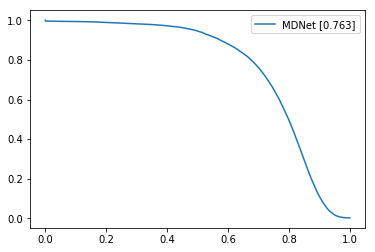

In [12]:
plt.plot(x_iou, perf_iou, label='MDNet [%.3f]' % (sum(perf_iou) / len(perf_iou)))
plt.legend()
plt.show()

In [13]:
cle = np.asarray([location(g, b) for gt, bb in zip(gtboxes, results) for g, b in zip(gt, bb)])

In [14]:
x_cle = np.arange(0, 50, .1)

In [15]:
perf_cle = [cle[np.where(cle<=flag)].size / cle.size for flag in x_cle]

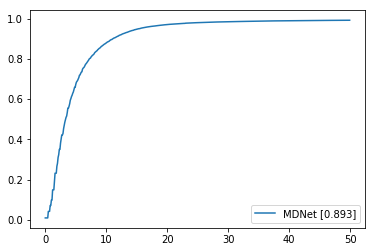

In [16]:
plt.plot(x_cle, perf_cle, label='MDNet [%.3f]' % (sum(perf_cle) / len(perf_cle)))
plt.legend()
plt.show()

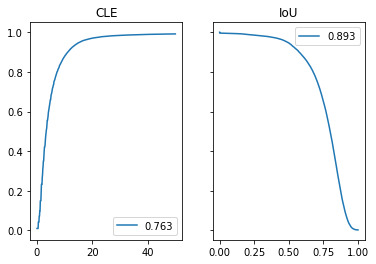

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x_cle, perf_cle, label='%.3f' % (sum(perf_iou) / len(perf_iou)))
ax1.set_title('CLE')
ax1.legend()
ax2.plot(x_iou, perf_iou, label='%.3f' % (sum(perf_cle) / len(perf_cle)))
ax2.set_title('IoU')
ax2.legend()

So, we get performance in pyMDNet implementation as below.

|           | CLE  | IOU  |
| --------- | ---- | ---- |
| paper     | .909 | .678 |
| implement | .893 | .763 |